<a href="https://colab.research.google.com/github/urieliram/tc_uc/blob/main/Figures_TC_UC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
# load packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# Gráficos
# ==============================================================================
from matplotlib import style
import seaborn as sns
cm = 1/2.54

# Modelado y test estadísticos Kolmogorov–Smirnov
# ============================================================================
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import ks_2samp
from scipy import stats


# Preprocesado y análisis
# ==============================================================================
from scipy import stats
from scipy.stats import shapiro

# Configuración matplotlib
# ==============================================================================
# Gráficos distribución observada 
# ============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight')
import seaborn as sns
plt.style.use('ggplot')

# GRÁFICOS DE CONVERGENCIA milp, milp2, hard3, harjk lbc, ks, 


## Lectura de archivos log

In [34]:
## Lectura de datos
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Log1.zip to Log1.zip
User uploaded file "Log1.zip" with length 208392 bytes


In [35]:
# !pip install unrar
# !unrar x "/content/Logs1.rar"

In [36]:
!unzip "Log1.zip" -d "/content"

Archive:  Log1.zip
  inflating: /content/Log_071.log    
  inflating: /content/Log_072.log    
  inflating: /content/logfileMilp2uc_072.log  
  inflating: /content/logfileMilp2uc_071.log  
  inflating: /content/logfileMilp2uc_065.log  
  inflating: /content/logfileMilp2uc_064.log  
  inflating: /content/logfileMilp2uc_063.log  
  inflating: /content/logfileMilp2uc_061.log  
  inflating: /content/Log_065.log    
  inflating: /content/Log_064.log    
  inflating: /content/Log_063.log    
  inflating: /content/Log_074.log    
  inflating: /content/logfileMilp2uc_074.log  
  inflating: /content/Log_061.log    
  inflating: /content/logfileMilp2uc_073.log  
  inflating: /content/Log_073.log    
  inflating: /content/Log_066.log    
  inflating: /content/logfileMilp2uc_066.log  
  inflating: /content/Log_075.log    
  inflating: /content/logfileMilp2uc_075.log  
  inflating: /content/logfileMilp2uc_067.log  
  inflating: /content/Log_067.log    
  inflating: /content/Log_076.log    
  inflat

In [37]:
def validateFiles():
  list=[]
  f = open("/content/Logs.txt","r")
  validFiles = [i.replace("\n","") for i in f]
  #print(validFiles)
  f.close()
  onlyfiles = [f.split(".")[0] for f in listdir("/content") if isfile(join("/content", f))]
  for i in validFiles:
    list.append(i)
    if i not in onlyfiles:
      return False
  return True, list
list=[]
if validateFiles() is False:
   print("!!! Faltan archivos")   
   temp, list = validateFiles()
   print(list)
else:
   temp, list = validateFiles()
   print("Archivos completos")
   

Archivos completos


## Extrae información de los logs

In [38]:
class ExtractCPLEX:

  def findPos(self,file,spected, starter = "Node  Left"):
    file = open(file,"r")
    for i,j in enumerate(file):
      if starter in j:
        return [(j.index(k)+len(k)-1) for k in spected]
  
  def getFilelog(self,f):
    with open(f, 'r') as file:
      data = file.read().replace('\n', '')
    tmp = []
    for i in re.findall(r"\w*Logfile\s*\'*[a-zA-z.+]*\'",data):
      tmp.append(i.replace("'","").split(" ")[1])
    return tmp

  def createTables(self,fn):
    table_start = False
    spected = ['Node', 'Left', 'Objective', 'IInf', 'Integer', 'Bound', 'ItCnt', 'Gap']
    expectedPositions = self.findPos(fn,spected)
    tables = {"seconds":[],"ticks":[],"solution":[],"Node":[],"Left":[],"Objective":[],"IInf":[],"Integer":[],"Bound":[],"ItCnt":[],"Gap":[],"cuts":[]}
    time = None
    ticks = None
    cuts = None
    f = open(fn,"r")    
    for i in f:
      if re.findall(r"\d{1,}[+]{1}\d{1,}",i):
        i = " ".join(i.split("+"))
      if("Cover cuts applied" in i or "Performing restart 1" in i):
        table_start = False
      if("Elapsed time" in i):
          tmp = [float(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
          time = tmp[0]
          ticks = tmp[1]
      if(table_start):        
        if((str(i)[0] == " " or str(i)[0] == "*") and str(i)[expectedPositions[0]].isdigit()):
          i = i.replace("uts: "," uts:")
          tables["seconds"].append(time)
          tables["ticks"].append(ticks)
          tables["solution"].append(1 if i[0]=="*" else 0)
          tables["cuts"].append(None)
          for j,m in zip(expectedPositions,spected):
            if i[j] != " ":
              tmp = ""
              for k in range(j,0,-1):
                if i[k] != " ":
                  tmp += i[k]
                else: 
                  break 
              tmp = tmp[::-1]
              if("ut" in tmp.lower() or "infeasible" in tmp.lower() or "integral" in tmp.lower()):
                if("uts" in tmp.lower()):
                  tables["cuts"][-1] = int(tmp.split(":")[1])
                tables[m].append(tables[m][-1])
              else:
                if m == "Gap":
                  tables[m].append(float(tmp)/100)
                else: 
                  tables[m].append(float(tmp))
            else:
              tables[m].append(None)
      if("Node  Left"):
        table_start = True

    return tables

  def extract(self,fn):
    variables = {"mipPresolveEliminated":[],"mipPresolveModified":[],"aggregatorDid":[],"reducedMipHasColumns":[],"reducedMipHasNonZero":[],"reducedMipHasBinaries":[],"reducedMipHasGeneral":[],"cliqueTableMembers":[],"rootRelaxSolSeconds":[],"rootRelaxSolTicks":[]}
    variables["logFile"] = self.getFilelog(fn)
    tables = self.createTables(fn)
    f = open(fn, "r")    
    for i in f:
      if("linear optimization" in i):
        variables["linearOpt"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("optimality gap tolerance" in i):
        variables["gapTol"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("time limit in seconds" in i):
        variables["timeLimit"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("emphasis for MIP optimization" in i):
        variables["mipOpt"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("Objective sense" in i):
        variables["objSense"] = i.replace(" ","").replace("\n","").split(":")[1]
      if("Variables" in i):
        if("Box:" in i):
          variablesValue = ["variablesValue","Nneg","Box","Binary"]
          for j,k in enumerate(re.findall(r'\d+', i.replace(" ","").replace("\n","").split(":",1)[1])):
            variables[variablesValue[j]] = float(k)
        else:
          variablesValue = ["minLB","maxUb"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
      if("Objective nonzeros" in i):
        if("Min" in i or "Max" in i):
          variablesValue = ["objNonZerosMin","objNonZerosMax"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          variables["objNonZeros"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("Linear constraints" in i):
        if("Less" in i):
          variablesValue = ["linearConstraintsValue","less","greater","equal"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          pass
      if("Nonzeros" in i):
        if("Min" in i):
          variablesValue = ["nonZerosMin","nonZerosMax"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          variables["nonZeros"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("RHS nonzeros" in i):
        if("Min" in i):
          variablesValue = ["rhsNonZerosMin","rhsNonZerosMax"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          variables["rhsNonZeros"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("CPXPARAM_TimeLimit" in i):
        variables["CPXPARAM_TimeLimit"] = float(i.replace("\n","").split(" ")[-1])
      if("MIP Presolve eliminated" in i):
        variables["mipPresolveEliminated"].append([int(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)])
      if("MIP Presolve modified " in i):
        variables["mipPresolveModified"].append(int(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)[0]))
      if("Reduced MIP has" in i):
        if("indicators." in i):
          tmp = [int(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
          variables["reducedMipHasBinaries"].append(tmp[0])
          variables["reducedMipHasGeneral"].append(tmp[1])
        else:
          tmp = [int(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
          variables["reducedMipHasColumns"].append(tmp[1])
          variables["reducedMipHasNonZero"].append(tmp[-1])
          reduceHasGeneral = []
      if("Clique" in i):
        variables["cliqueTableMembers"].append(float(i.replace(" ","").replace("\n","").split(":")[1]))
      if("Aggregator did" in i):
        variables["aggregatorDid"].append(int(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)[0]))
      if("Root relaxation" in i):
        tmp = [float(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
        variables["rootRelaxSolSeconds"].append(tmp[0])
        variables["rootRelaxSolTicks"].append(tmp[1])
      if("Lift and" in i):
        variables["liftAndProjectCuts"] = int(i.replace(" ","").replace("\n","").split(":")[1])
      if("Gomory fractional" in i):
        variables["gomoryFract"] = int(i.replace(" ","").replace("\n","").split(":")[1])

    df=pd.DataFrame.from_dict(tables).rename(columns={"seconds":"seconds","ticks":"ticks","solution":"solution","Node":"node","Left":"nodesLeft","Objective":"objective","IInf":"iinf","Integer":"bestInteger","Bound":"BestBound","ItCnt":"itCnt","Gap":"gap","cuts":"cuts"})
    df['seconds'] = df['seconds'].fillna(0)
    eps=np.arange(0, 1, 1/(len(df)), dtype=float)
    df['eps'] = eps
    sum_column = df["seconds"] + df["eps"]
    df["seconds"] = sum_column
    df['ticks'] = df['ticks'].fillna(0)
    eps=np.arange(0, 1, 1/(len(df)), dtype=float)
    df['eps'] = eps
    sum_column = df["ticks"] + df["eps"]
    df["ticks"] = sum_column
    return df,variables

In [39]:
class Extract:
  def __init__(self,log):
    self.log = log 
  def getFilelog(self,f):
    with open(f, 'r') as file:
      data = file.read().replace('\n', '')
    tmp = []
    for i in re.findall(r"\w*"+self.log+"\s*\'*[a-zA-z.+]*\'",data):
      print(i)
      tmp.append(i.replace("'","").split(" ")[1])
    return tmp
  def extract(self):
    fn= "/content/"+self.log+".log"
    variables = {}
    variables["logFile"] = self.log.replace("Log","uc")
    f = open(fn, "r")
    for i in f:
      # if("z_milp=" in i):
      #   variables["z_milp"]  = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("z_milp2=" in i):
        variables["z_milp2"] = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("z_harjk=" in i):
        variables["z_harjk"] = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("z_hard3=" in i):
        variables["z_hard3"] = float(i.replace(" ","").replace("\n","").split("=")[1])        
      # if("t_milp=" in i):
      #   variables["t_milp"]  = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("t_milp2=" in i):
        variables["t_milp2"] = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("t_harjk=" in i):
        variables["t_harjk"] = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("t_hard3=" in i):
        variables["t_hard3"] = float(i.replace(" ","").replace("\n","").split("=")[1])

    # variables["flag_milp" ] = False
    variables["flag_milp2"] = False
    variables["flag_harjk"] = False
    variables["flag_hard3"] = False

    # if variables["z_milp"]  != 1E+75:
    #   variables["flag_milp"] = True
    if variables["z_milp2"] != 1E+75:
      variables["flag_milp2"] = True
    if variables["z_harjk"] != 1E+75:
      variables["flag_harjk"] = True
    if variables["z_hard3"] != 1E+75:
      variables["flag_hard3"] = True

    start = ["lbc1 results","lbc2 results","lbc3 results","lbc4 results","KS results"]
    stop  = ["lbc1 end"    ,"lbc2 end"    ,"lbc3 end"    ,"lbc4 end"    ,"KS end"    ]
    for p in range(5):
      pattern_start = re.compile(r""+start[p])
      pattern_stop  = re.compile(r""+"^"+stop[p])
      i = 0
      extract_on = False
      extracts = []
      with open(r''+fn, 'rt') as myfile:
          for line in myfile:
              i += 1  # line counting starts with 1
              if pattern_start.match(line):
                  extract_on = True
              if pattern_stop.search(line):
                  extract_on = False
              if extract_on:
                  extracts.append((i, line.rstrip('\n')))
      listlines=[]; x=[]; y=[]
      for line in extracts:
        listlines.append(line[1])
      if len(listlines)!=0:
        del listlines[0]
      for i in listlines:
        if float(re.split(',',i.replace(" ",""))[1])!=1E+75:
          x.append(float(re.split(',',i.replace(" ",""))[0]))
          y.append(float(re.split(',',i.replace(" ",""))[1]))

      if p==0:
        variables["t_lbc1"] = x
        variables["z_lbc1"] = y
        variables["flag_lbc1"] = True
      if p==1:
        variables["t_lbc2"] = x
        variables["z_lbc2"] = y
        variables["flag_lbc2"] = True
      if p==2:
        variables["t_lbc3"] = x
        variables["z_lbc3"] = y
        variables["flag_lbc3"] = True
      if p==3:
        variables["t_lbc4"] = x
        variables["z_lbc4"] = y
        variables["flag_lbc4"] = True
      if p==4:
        variables["t_KS"] = x
        variables["z_KS"] = y
        variables["flag_KS"] = True

    return variables

ex         = Extract('Log_061')
variablesx = ex.extract()
print(variablesx)

{'logFile': 'uc_061', 't_hard3': 1214.8, 'z_hard3': 22348839.6, 't_harjk': 1214.9, 'z_harjk': 22358438.4, 't_milp2': 7234.4, 'z_milp2': 22342342.0, 'flag_milp2': True, 'flag_harjk': True, 'flag_hard3': True, 't_lbc1': [1214.7881741523743, 1330.7, 2547.9, 3765.2, 4982.9, 7219.9], 'z_lbc1': [22348839.580970775, 22348839.580970775, 22343549.107091032, 22342341.971034825, 22342341.971034776, 22342341.971034776], 'flag_lbc1': True, 't_lbc2': [1214.7881741523743, 1332.9, 2551.1, 3769.4, 4987.8, 7220.3], 'z_lbc2': [22348839.580970775, 22348839.580970775, 22344609.107091248, 22342341.971034836, 22342341.97103478, 22342341.97103478], 'flag_lbc2': True, 't_lbc3': [1214.7881741523743, 1332.9, 2551.3, 3769.5, 4987.9, 7220.2], 'z_lbc3': [22348839.580970775, 22348839.580970775, 22347152.112599537, 22346065.36259932, 22346065.36259877, 22345005.362600006], 'flag_lbc3': True, 't_lbc4': [1214.7881741523743, 1352.5, 2569.4, 3788.4, 5007.4, 7219.2], 'z_lbc4': [22348839.580970775, 22348839.580970775, 2234

## Despliega gráficas

In [40]:
## Test ExtractCPLEX
#e = ExtractCPLEX()
#df, dic = e.extract("/content/logfileMilp2uc_061.log")
#df.plot.line( x='seconds',y='bestInteger',style='o-',label='_nolegend_')

In [41]:
def graficas(title='',graphs=[]):
  plt.figure()
  models = ['MILP2','Harjk','Harduc','LB1','LB2','LB3','LB4','KS']
  i=0
  for tup in graphs:
      x    = tup[0]
      y    = tup[1]
      if tup[2]:
        if i==0:
          plt.plot(x, y, 'x',  label = models[i],markersize=7,color='magenta')
        else:
          plt.plot(x, y, '.-', label = models[i],markersize=7,)
      i=i+1

  if title !='uc_063':
    if title !='uc_064':
      if title !='uc_065':
        if title !='uc_066':      
          if title !='uc_067':
            if title !='uc_068':
              e = ExtractCPLEX()
              df, dic = e.extract("/content/logfileMilp2"+title+".log")
              a = df['seconds'].values.tolist()
              ar = np.array(a)
              ar = ar + 1200 ##Agregamos los segundos de Harduc
              plt.plot( ar,df['bestInteger'].values.tolist(),'x',color='magenta')

  plt.xlabel("Time (seconds)")
  plt.ylabel("z ($)")
  plt.title('Instance '+title)
  plt.legend(bbox_to_anchor=(1, 0.75))
  plt.tight_layout()
  plt.savefig('fig:'+title+'.pdf')
  # plt.show()
  return 0

In [ ]:
for item in list:
    list2  = []
    graphs = []
    try:
      e = Extract(item)
      variables = e.extract()
      if True:
        variables["flag_harjk"] = False
        # graphs.append(([variables['t_milp' ]],[variables['z_milp']] ,variables["flag_milp"]))
        graphs.append(([variables['t_milp2']],[variables['z_milp2']],variables["flag_milp2"]))
        graphs.append(([variables['t_harjk']],[variables['z_harjk']],variables["flag_harjk"]))
        graphs.append(([variables['t_hard3']],[variables['z_hard3']],variables["flag_hard3"]))
        graphs.append((variables['t_lbc1' ],variables['z_lbc1' ],variables["flag_lbc1"]))
        graphs.append((variables['t_lbc2' ],variables['z_lbc2' ],variables["flag_lbc2"]))
        graphs.append((variables['t_lbc3' ],variables['z_lbc3' ],variables["flag_lbc3"]))
        graphs.append((variables['t_lbc4' ],variables['z_lbc4' ],variables["flag_lbc4"]))
        graphs.append((variables['t_KS' ],variables['z_KS' ],variables["flag_KS"]))
        graficas(title=variables["logFile"],graphs=graphs)
      list2.append(variables)
    except Exception as err:
      print("Fail in ", item+".log"+ " file")
      print(str(err))

## GRAFICOS DE BOXPLOT


In [43]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path = 'https://drive.google.com/uc?export=download&id=' 
URL  = 'https://drive.google.com/file/d/1ySF5y3FdEZrEAu1jZ_P1PdBJSk64TQvt/view?usp=share_link'
df   = pd.read_csv(path+URL.split('/')[-2],header=0)
##      z_milp	z_feas	z_harjk	 z_hard3	z_lbc1	z_lbc2	z_lbc3	z_ks    (09-16)
##    	t_milp	t_feas	t_harjk  t_hard3	t_lbc1	t_lbc2	t_lbc3	t_ks    (18-26)
##      g_milp	g_feas	g_harjk	 g_hard3	g_lbc1	g_lbc2	g_lbc3	g_ks    (28-35)
df.dropna(inplace=True)

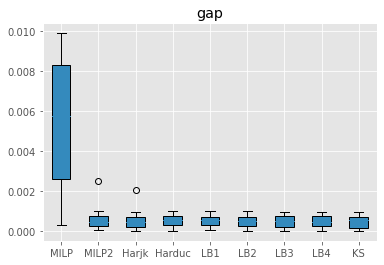

In [44]:
##Imprimir GAP
data1  = df.g_milp.to_numpy()
data2  = df.g_milp2.to_numpy()
data3  = df.g_harjk.to_numpy()
data4  = df.g_hard3.to_numpy()
data5  = df.g_lbc1.to_numpy()
data6  = df.g_lbc2.to_numpy()
data7  = df.g_lbc3.to_numpy()
data8  = df.g_lbc4.to_numpy()
data9  = df.g_ks.to_numpy()
labels = ['MILP','MILP2','Harjk','Harduc','LB1','LB2','LB3','LB4','KS']
x=[data1,data2,data3,data4,data5,data6,data7,data8,data9]
fig,ax = plt.subplots()
ax.set_title('gap')
bp = ax.boxplot(x,           
positions=[1,2,3,4,5,6,7,8,9],      # where to put these arrays
labels = labels, patch_artist=True)  # allow filling the box with colors
# ax.legend()
namefile = 'fig:boxplotgap'+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()

## Análisis estadístico descriptivo

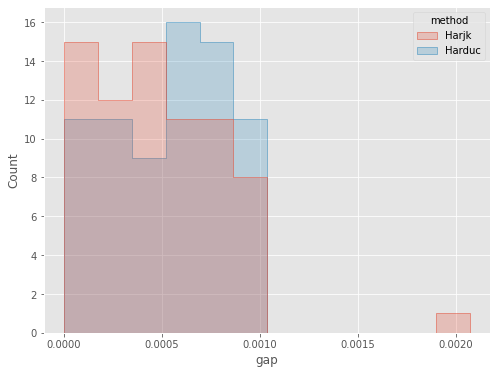

In [72]:
## https://www.geeksforgeeks.org/data-visualization-with-python-seaborn/
fig, ax = plt.subplots(figsize=(8, 6))
method  = ['Harjk' ]*(len(data3))
method2 = ['Harduc']*(len(data4))
method  = method + method2
data    = np.concatenate((data3, data4), axis=0)
# initialise data of lists.
data = {'gap'       :data,
        'method'  :method}  
df1 = pd.DataFrame( data )
sns.histplot(df1, x="gap", hue="method", element="step")
# sns.distplot(df1, x="z", hist=True, kde=True, hist_kws={'edgecolor': 'black'}, kde_kws={'linewidth': 2}, bins=10,color='green')

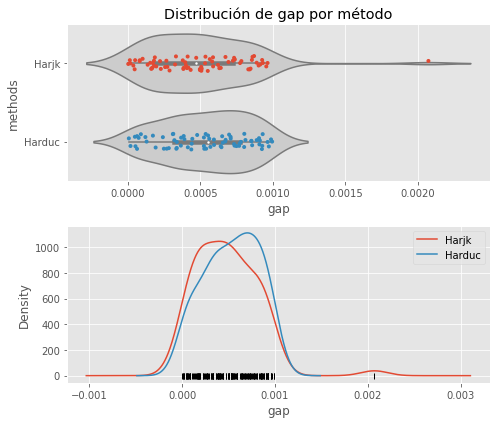

In [57]:
if True:
  import seaborn as sns
  fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 6))
  sns.violinplot(
      x       = df1.gap,
      y       = df1.method,
      color   = '.8',
      ax      = axs[0]  )
  sns.stripplot(
      x       = df1.gap,
      y       = df1.method,
      data    = df1,
      size    = 4,
      jitter  = 0.1,
      ax      = axs[0]  )
  axs[0].set_title('Distribución de gap por método')
  axs[0].set_ylabel('methods')
  axs[0].set_xlabel('gap');

  for i in df1.method.unique():
      datos_temp = df1[df1.method == i]['gap']
      datos_temp.plot.kde(ax=axs[1], label=i)
      axs[1].plot(datos_temp, np.full_like(datos_temp, 0), '|k', markeredgewidth=1)

  axs[1].set_xlabel('gap');
  axs[1].legend()

  fig.tight_layout();

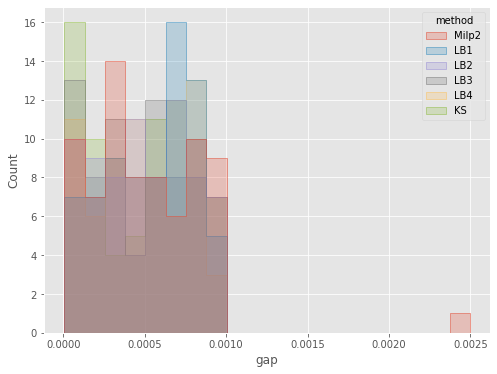

In [115]:
## https://www.geeksforgeeks.org/data-visualization-with-python-seaborn/
fig, ax = plt.subplots(figsize=(8, 6))
method1 = ['Milp2' ]*(len(data2))
method2 = ['LB1'   ]*(len(data5))
method3 = ['LB2'   ]*(len(data6))
method4 = ['LB3'   ]*(len(data7))
method5 = ['LB4'   ]*(len(data8))
method6 = ['KS'    ]*(len(data9))
method  = method1 + method2 + method3 + method4 + method5 + method6
data    = np.concatenate((data2, data5, data6, data7, data8, data9), axis=0)
# initialise data of lists.
data = {'gap'       :data,
        'method'  :method}  
df1 = pd.DataFrame( data )
sns.histplot(df1, x="gap", hue="method", element="step") #,bins=15

## **Estadistica inferencial para los métodos contructivos**

### Pruebas de Normalidad

In [133]:
# conduct the  Shapiro-Wilk Test
## https://www.geeksforgeeks.org/how-to-perform-a-shapiro-wilk-test-in-python/
## This is a hypotheses test and the two hypotheses are as follows:
## Ho(Accepted): Sample is from the normal distributions.(Po>0.05)
## Ha(Rejected): Sample is not from the normal distributions.
## Example 1: Shapiro-Wilk test on the normally distributed sample in Python
## In this example, we will be simply using the shapiro() function from 
## the scipy.stats library to Conduct a Shapiro-Wilk test on the randomly generated data with 500 data points in python. 
samples= (data1,data2,data3,data4,data5,data6,data7,data8,data9)
labels = ['MILP','MILP2','Harjk','Harduc','LB1','LB2','LB3','LB4','KS']
i = 0
print('Shapiro-Wilk test')
for s in samples:
  # print(labels[i],':', shapiro(s).statistic, shapiro(s).pvalue)
  if shapiro(s).pvalue > 0.05:
    print(labels[i],'\t:',round(shapiro(s).statistic,4),round(shapiro(s).pvalue,4),'\tWe fail to reject the null hypothesis; Ho accepted: Sample is from the normal distributions.(Po>0.05)')
  else:
    print(labels[i],'\t:',round(shapiro(s).statistic,4),round(shapiro(s).pvalue,4),'\tWe reject the null hypothesis and accept Ha: Sample is not from the normal distributions.')
  i = i + 1
## Output Interpretation:
## Returns: (statistic: The test statistic, p-value: The p-value for the hypothesis test)
## a)Since in the above example, the p-value is 0.73 which is more than the threshold(0.05) which is the alpha(0.05) then we fail to reject the null hypothesis 
##   i.e. we do (not have sufficient evidence) to say that sample does not come from a normal distribution.
## b)Since in the above example, the p-value is 0.0001 which is less than the alpha(0.05) then we reject the null hypothesis 
##   i.e. we (have sufficient evidence) to say that sample does not come from a normal distribution.

Shapiro-Wilk test
MILP : 0.9245 0.0003 	We reject the null hypothesis and accept Ha: Sample is not from the normal distributions.
MILP2 : 0.8307 0.0 	We reject the null hypothesis and accept Ha: Sample is not from the normal distributions.
Harjk : 0.8958 0.0 	We reject the null hypothesis and accept Ha: Sample is not from the normal distributions.
Harduc : 0.9547 0.0104 	We reject the null hypothesis and accept Ha: Sample is not from the normal distributions.
LB1 : 0.9546 0.0103 	We reject the null hypothesis and accept Ha: Sample is not from the normal distributions.
LB2 : 0.9599 0.0204 	We reject the null hypothesis and accept Ha: Sample is not from the normal distributions.
LB3 : 0.9415 0.0021 	We reject the null hypothesis and accept Ha: Sample is not from the normal distributions.
LB4 : 0.9447 0.003 	We reject the null hypothesis and accept Ha: Sample is not from the normal distributions.
KS : 0.923 0.0003 	We reject the null hypothesis and accept Ha: Sample is not from the normal

### Pruebas de Homocedasticidad entre los resultados de Harduc Y Harjk

In [138]:
## homocedasticidad.
## https://www.cienciadedatos.net/documentos/pystats07-test-homocedasticidad-heterocedasticidad-python.html
## https://stats.stackexchange.com/questions/135232/bartletts-test-vs-levenes-test
## We conducting Levene’s Test or Bartlett’s Test of homogeneity of variance we are dealing with two hypotheses. These two are simply put:
## Ho(Accepted): the variances are equal across all samples
## Ha(Rejected): the variances are not equal across all samples

# Bartlett test
# ==============================================================================
# bartlett_test = stats.bartlett(data3, data4)
# print(bartlett_test.statistic,bartlett_test.pvalue)

# Levene test
# ==============================================================================
levene_test = stats.levene(data3, data4, center='median')
# print(levene_test.statistic,levene_test.pvalue)

# Fligner-Killeen
# ==============================================================================
fligner_test = stats.fligner(data3, data4, center='median')
# print(fligner_test.statistic,fligner_test.pvalue)
labels = ['Harjk','Harduc']
print('Levene test')
if levene_test.pvalue > 0.05:
    print('[Harjk,Harduc]\t:',round(levene_test.statistic,4),round(levene_test.pvalue,4),'\tWe fail to reject the null hypothesis; Ho accepted: the variances are equal across all samples. (Po>0.05)')
else:
    print('[Harjk,Harduc]\t:',round(levene_test.statistic,4),round(levene_test.pvalue,4),'\tWe reject the null hypothesis and accept Ha: the variances are not equal across all samples. (Po<=0.05)')

print('Fligner test')
if fligner_test.pvalue > 0.05:
    print('[Harjk,Harduc]\t:',round(fligner_test.statistic,4),round(fligner_test.pvalue,4),'\tWe fail to reject the null hypothesis; Ho accepted: the variances are equal across all samples. (Po>0.05)')
else:
    print('[Harjk,Harduc]\t:',round(fligner_test.statistic,4),round(fligner_test.pvalue,4),'\tWe reject the null hypothesis and accept Ha: the variances are not equal across all samples. (Po<=0.05)')

## Output Interpretation:
## a) This means, for example, that if we get a p-value larger than 0.05 we can assume 
## hat our data is heteroscedastic and we can continue carrying out a parametric test 
## such as the two-sample t-test. 
## b) If we, on the other hand, get a statistically 
## significant result we may want to carry out the Mann-Whitney U test. 
## Ninguno de los test muestra evidencias para rechazar la hipótesis de que los 
## dos grupos tienen la misma varianza, homocedasticidad. p-value >>>> 0.05

Levene test
[Harjk,Harduc]	: 0.3812 0.5379 	We fail to reject the null hypothesis; Ho accepted: the variances are equal across all samples. (Po>0.05)
Fligner test
[Harjk,Harduc]	: 0.0084 0.9271 	We fail to reject the null hypothesis; Ho accepted: the variances are equal across all samples. (Po>0.05)


## Wilcoxon test between Harduc and Harjk

https://pythonfordatascienceorg.wordpress.com/wilcoxon-sign-ranked-test-python/
https://www.geeksforgeeks.org/how-to-conduct-a-wilcoxon-signed-rank-test-in-python/

In [144]:
import scipy.stats as stats
## Ho(Accepted): The difference between the pairs follows a symmetric distribution around zero.
## Ha(Rejected): The difference between the pairs does not follow a symmetric distribution around zero.

data3  ## harjk
data4  ## harduc

## We conduct the Wilcoxon-Signed Rank Test {“two-sided”, “greater”, “less”}, optional
print(stats.wilcoxon(data3, data4, alternative='greater'))

print('Wilcoxon-Signed Rank test')
if stats.wilcoxon(data3, data4, alternative='greater').pvalue > 0.05:
    print('[Harjk,Harduc]\t:','We fail to reject the null hypothesis; Ho accepted: The median difference between the pairs follows a symmetric distribution around zero.')
else:
    print('[Harjk,Harduc]\t:','We reject the null hypothesis and accept Ha: The median difference is positive α=0.05.')

## Output Interpretation:
## In the above example, the p-value is 0.2 which is less than the threshold(0.05) which is the alpha(0.05) 
## i.e. p-value<alpha which means the sample is of the same distribution 
## and the sample distributions are equal if in the case if the p-value>0.05 than it would be opposite.


WilcoxonResult(statistic=1157.0, pvalue=0.8562851539207134)
Wilcoxon-Signed Rank test
[Harjk,Harduc]	: We fail to reject the null hypothesis; Ho accepted: The median difference between the pairs follows a symmetric distribution around zero.


### Wilcoxon test
https://www.geeksforgeeks.org/how-to-conduct-a-wilcoxon-signed-rank-test-in-python/

https://pythonfordatascienceorg.wordpress.com/wilcoxon-sign-ranked-test-python/

https://www.cienciadedatos.net/documentos/18_prueba_de_los_rangos_con_signo_de_wilcoxon

Comparaxion medias

https://www.cienciadedatos.net/documentos/pystats11-wilcoxon-mann-whitney-u-test-python

https://www.cienciadedatos.net/documentos/pystats10-t-test-python.html

https://www.cienciadedatos.net/documentos/pystats09-analisis-de-varianza-anova-python.html

https://www.cienciadedatos.net/documentos/15_inferencia_para_proporciones

## Friedman test

https://www.statology.org/friedman-test-python/

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.friedmanchisquare.html

In [55]:
group1 = [4, 6, 3, 4, 3, 2, 2, 7, 6, 5]
group2 = [5, 6, 8, 7, 7, 8, 4, 6, 4, 5]
group3 = [2, 4, 4, 3, 2, 2, 1, 4, 3, 2]
data2  = df.g_milp2.to_numpy()
data5  = df.g_lbc1.to_numpy()
data6  = df.g_lbc2.to_numpy()
data7  = df.g_lbc3.to_numpy()
data8  = df.g_lbc4.to_numpy()
data9  = df.g_ks.to_numpy()

In [56]:
stats.friedmanchisquare(group1, group2, group3)

FriedmanchisquareResult(statistic=13.351351351351344, pvalue=0.0012612201221243594)

## Descartes

Distancia Kolmogorov–Smirnov: {distancia_ks :.4f}


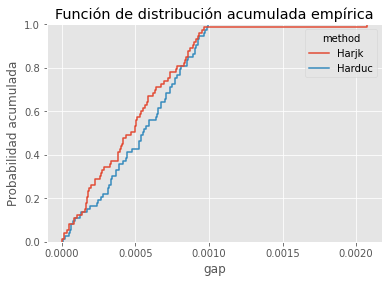

In [47]:
## https://www.cienciadedatos.net/documentos/pystats08-comparacion-distribuciones-test-kolmogorov-smirnov-python.html
# Representación gráfica de las curvas ecdf
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
sns.ecdfplot(data=df1, x='gap', hue='method', ax=ax)
ax.set_title("Función de distribución acumulada empírica")
ax.set_ylabel("Probabilidad acumulada");
# Ajuste de las funciones ecdf con cada muestra
# ==============================================================================
ecdf_harjk  = ECDF(df1.loc[df1.method == 'Harjk' , 'gap'])
ecdf_harduc = ECDF(df1.loc[df1.method == 'Harduc', 'gap'])
# Estimación de la probabilidad acumulada de cada valor de salario observado
# ==============================================================================
grid_gap = np.sort(df1.gap.unique())
prob_acumulada_ecdf_harjk  = ecdf_harjk( grid_gap)
prob_acumulada_ecdf_harduc = ecdf_harduc(grid_gap)
# Distancia Kolmogorov–Smirnov
# ==============================================================================
abs_dif = np.abs(prob_acumulada_ecdf_harjk - prob_acumulada_ecdf_harduc)
distancia_ks = np.max(abs_dif)
print("Distancia Kolmogorov–Smirnov: {distancia_ks :.4f}")

In [45]:
# Conduct the Kruskal-Wallis Test
result = stats.kruskal(data2,data5,data6,data7,data8,data9)

# Print the result
print(result)
#Kruskal-Wallis test discussion:  In this example, the test statistic comes out to be equal to 87 and the corresponding p-value is 2.1856E-17. 
#(As the p-value is not less than 0.05, we cannot reject the null hypothesis that the median of optimality gap is the same for all groups. Hence, We don’t have sufficient proof to claim that the different types of methods used to lead to statistically significant differences in the acuracy of methods.)
#(As the p-value is less than 0.05, we reject the null hypothesis that the median of optimality gap is the same for all groups. Hence, We don’t have sufficient proof to reject that the different types of methods used to lead to statistically significant differences in the acuracy of methods.)

KruskalResult(statistic=2.1300269168016257, pvalue=0.8308765529861137)
